Bachelor thesis - 7337876 - University of Cologne - A spatio-temporal analysis of usage patterns in free-floating shared mobility


# Clustering Trip Types Based On Centrality And Duration

This notebook contains the identification of trip types. Following steps are performed:
* Feature selection
* Feature scaling via MinMaxScaler
* Clustering of trip types via k-means
* Evaluation of clustering (select k)
* Interpretation and visualization of cluster results
* Distribution of identified trip types among mobility modes

### Imports

In [1]:
import pandas as pd
import glob

import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_theme(style="white")

from sklearn.preprocessing import MinMaxScaler


from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

import time
# import numpy as np

### Load Data

In [2]:
# load monthly data of mode based on selected months
def load_data(mode, months):
    first_read = True
    
    for month in months:
        data_month = pd.concat([pd.read_csv(file) for file in glob.glob('Data/Modes/data_supplemented_{}_{}.csv'.format(mode, month))], ignore_index = True)
        if (first_read):
            data_full = data_month
            first_read = False
        else:
            data_full = pd.concat([data_full, data_month], ignore_index=True)
    
    return data_full

# load full data of mode
def load_data_mode_full(mode):
    data_mode_full = pd.read_csv('Data/Modes/data_supplemented_full_{}.csv'.format(mode))
    
    return data_mode_full

In [3]:
# define months for data loading (YYYYMM)
months = ['201911', '201912', '202001', '202002']

#load data by months
load_monthly_data = False

if (load_monthly_data):
    data_car = load_data('car', months)
    data_bicycle = load_data('bicycle', months)
    data_scooter = load_data('scooter', months)
    data_full = pd.concat([data_car, data_bicycle, data_scooter], ignore_index=True)

In [4]:
# read in desired data
# set True if full data set load is desired
load_full_data = True

if (load_full_data):
    data_car = load_data_mode_full('car')
    data_bicycle = load_data_mode_full('bicycle')
    data_scooter = load_data_mode_full('scooter')
    data_full = pd.concat([data_car, data_bicycle, data_scooter], ignore_index=True)

### Feature selection

In [5]:
# select only dist features (based on manuelly defined trip types in literature) and id + vehicleType for later interpretation

dfa = data_full[['id','vehicleType','dist_center_start','dist_center_end', 'duration']].copy()
df = dfa.sample(n=30000, random_state=1)

#df = data_full[['id','vehicleType','dist_center_start','dist_center_end', 'duration']].copy()

df['duration'] = df['duration'] / 60
df.columns

Index(['id', 'vehicleType', 'dist_center_start', 'dist_center_end',
       'duration'],
      dtype='object')

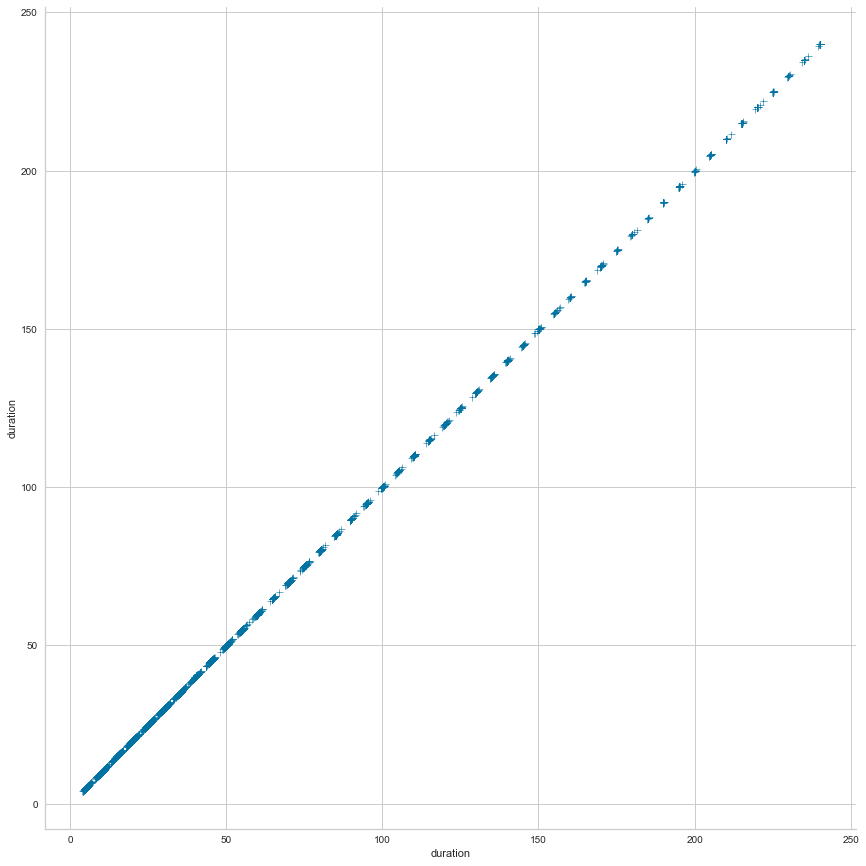

In [6]:
# plot features to visually observe structure of data
g = sns.relplot(x="duration", y="duration", kind="scatter", data=df, marker='+', height=12, aspect=1)

In [7]:
df['duration'].max()

240.0

In [8]:
from scipy.stats import zscore
import numpy as np

# remove extreme outliers
# data values that have a z-score sigma greater than a threshold of 4, are declared to be outliers.
z_scores = zscore(df[['dist_center_start','dist_center_end','duration']])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 4).all(axis=1)
df = df[filtered_entries]
df


#df = df[(df['dist_center_start']<11000)&(df['dist_center_end']<11000)]

# plot indicates four interpretable convex clusters
#g = sns.relplot(x="dist_center_start", y="dist_center_end", kind="scatter", data=df, marker='+', height=12, aspect=1)




,id,vehicleType,dist_center_start,dist_center_end,duration
120814,ZnJlZWZsb2F0OjpjYXIyZ286OldEQzE1Njk0MjFKNjEyMjMw,car,1986,3290,20.000000
60088,ZnJlZWZsb2F0OjpjYXIyZ286OldERDE3NzA0NDFKMTEwOTcz,car,4756,1625,50.016667
46984,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMjkzMDI4,car,4353,525,40.000000
146684,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLNDA4MzE1,car,2169,2844,30.000000
198253,ZnJlZWZsb2F0OjpjYXIyZ286OldNV1hSMTEwMDBURTU3ODA0,car,1586,2935,25.033333
...,...,...,...,...,...
71725,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMjczNjUw,car,1384,1149,64.716667
373590,YmlrZTo6dGllcjo6ZmZiNjJlZDctZjBiMi00OGMxLWE2NT...,scooter,4465,4396,9.966667
330644,YmlrZTo6dGllcjo6ZWQwNDdiMWQtZGQxYy00MTgzLTlhZm...,scooter,3646,571,25.016667
202888,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMzg0NTA5,car,1970,3675,50.016667


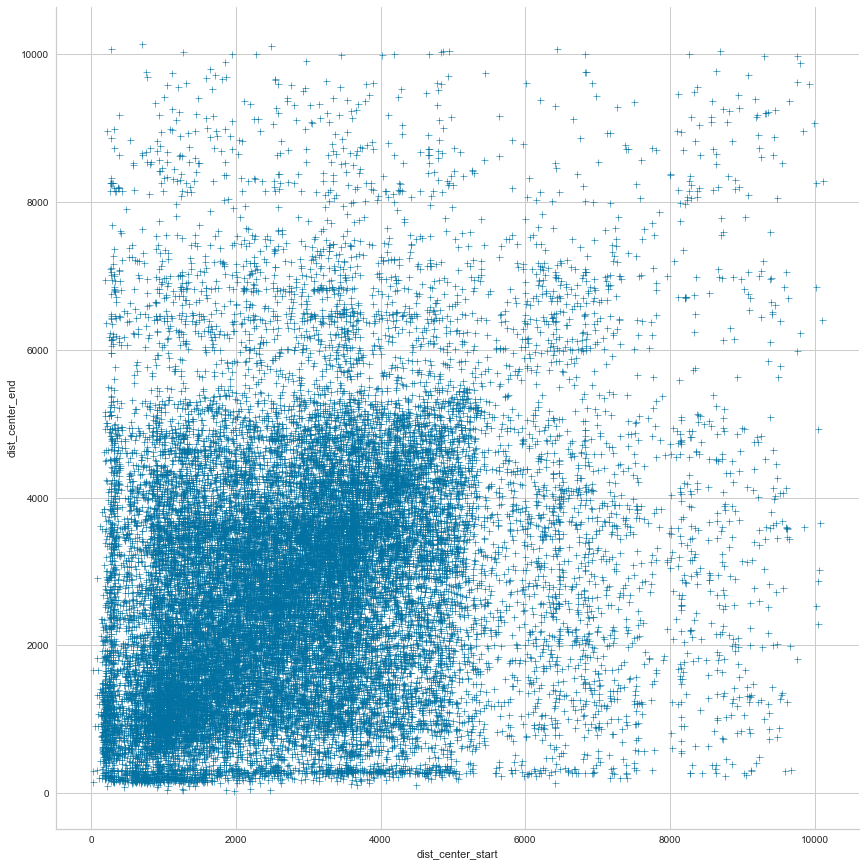

In [9]:
g = sns.relplot(x="dist_center_start", y="dist_center_end", kind="scatter", data=df, marker='+', height=12, aspect=1)

### Feature scaling

(array([0, 1, 2]),
 [Text(0, 0, 'dist_center_start'),
  Text(1, 0, 'dist_center_end'),
  Text(2, 0, 'duration')])

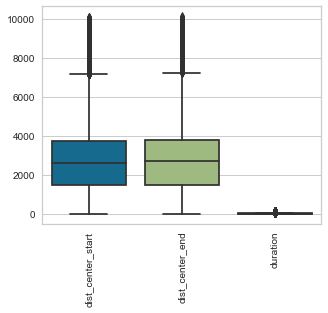

In [10]:
# look at feature skewness
plt.figure(figsize=(5,4))
sns.boxplot(data=df)
plt.xticks(rotation=90)

In [11]:
df_minmax = df[['dist_center_start','dist_center_end', 'duration']].copy()

# save names
names = df_minmax.columns

# scale data
scaler = MinMaxScaler()
scaler.fit(df_minmax)
df_minmax = scaler.transform(df_minmax)

# convert scaled array into dataframe
scaled_df = pd.DataFrame(df_minmax, columns=names) 

scaled_df

,dist_center_start,dist_center_end,duration
0,0.194549,0.323046,0.114077
1,0.469078,0.158358,0.325885
2,0.429138,0.049555,0.255204
3,0.212686,0.278932,0.184641
4,0.154906,0.287933,0.149594
...,...,...,...
29394,0.134886,0.111276,0.429613
29395,0.440238,0.432443,0.043279
29396,0.359068,0.054105,0.149477
29397,0.192963,0.361128,0.325885


(array([0, 1, 2]),
 [Text(0, 0, 'dist_center_start'),
  Text(1, 0, 'dist_center_end'),
  Text(2, 0, 'duration')])

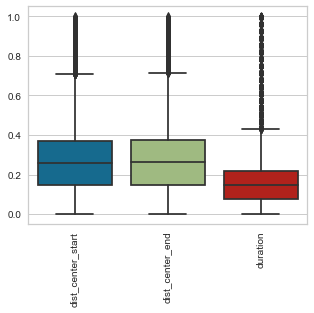

In [12]:
# visualize scaled features (still right skewed but scaled from 0 to 1 + 0 remains)
plt.figure(figsize=(5,4))
sns.boxplot(data=scaled_df)
plt.xticks(rotation=90)

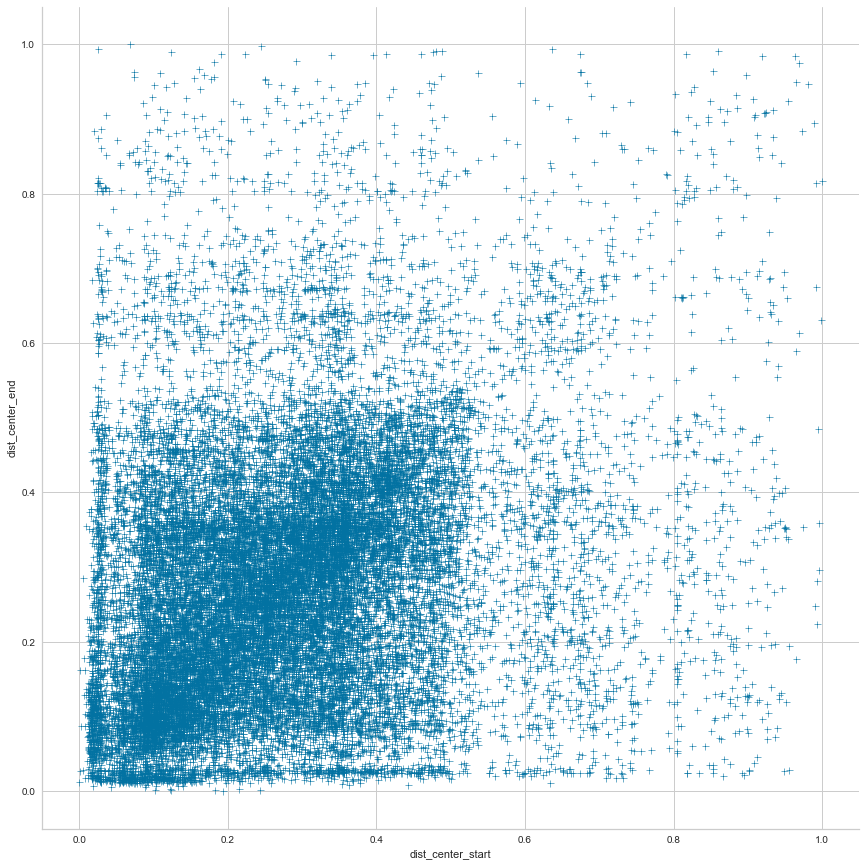

In [13]:
# plot still indicates four interpretable convex clusters
g = sns.relplot(x="dist_center_start", y="dist_center_end", kind="scatter", data=scaled_df, marker='+', height=12, aspect=1)

### Cluster Tendency

In [14]:
from pyclustertend import hopkins
hopkins(scaled_df, 20000)

0.13892922119403808

### Clustering trip types via k-means and parameter selection

In [15]:
# run k-means multiple times to identify "optimal" k
from sklearn import metrics
from sklearn.metrics import silhouette_score

# with-in cluster sum of squares
wcss=[]

# silhouette coefficients
silhouette_coefficients = []

# run loop
for i in range (2,15):   
    start = time.time()
    kmeans = KMeans(i)
    kmeans.fit(scaled_df)
    wcss.append(kmeans.inertia_)
    print(kmeans.inertia_)
    
    score = silhouette_score(scaled_df, kmeans.labels_)
    silhouette_coefficients.append(score)
    print(score)
    
    end = time.time()
    print(i)
    print(end - start)

1635.1386443765819
0.3180690650062172
2
19.548155546188354
1316.9210890450825
0.3143829252626987
3
14.810125589370728
1085.2731230930074
0.30178549709556657
4
14.109299421310425
916.8166287035573
0.2905833743669924
5
14.948273181915283
796.4519614084987
0.3048923369174835
6
16.23075580596924
693.8573207414705
0.3115543349821684
7
14.571767807006836
631.3543211295084
0.3130575007705994
8
14.252067565917969
575.5530764217133
0.2969194017323006
9
14.365162134170532
528.275911367906
0.2992543461985777
10
14.357163429260254
493.7462588010104
0.3004413425096534
11
15.4182710647583
470.3312178756004
0.277513789368824
12
17.15169644355774
447.70494925498633
0.2702269983113117
13
17.879475831985474
429.7110364910393
0.2665052740160397
14
17.10846519470215


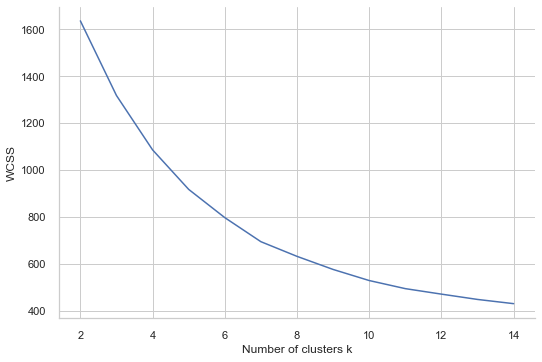

In [16]:
# plot elbow plot to visually pick "optimal" k
sns.set_theme(style="whitegrid")
g = sns.relplot(x=range(2,15), y=wcss, kind="line", height=5, aspect=1.5)
g.set_axis_labels('Number of clusters k', 'WCSS')

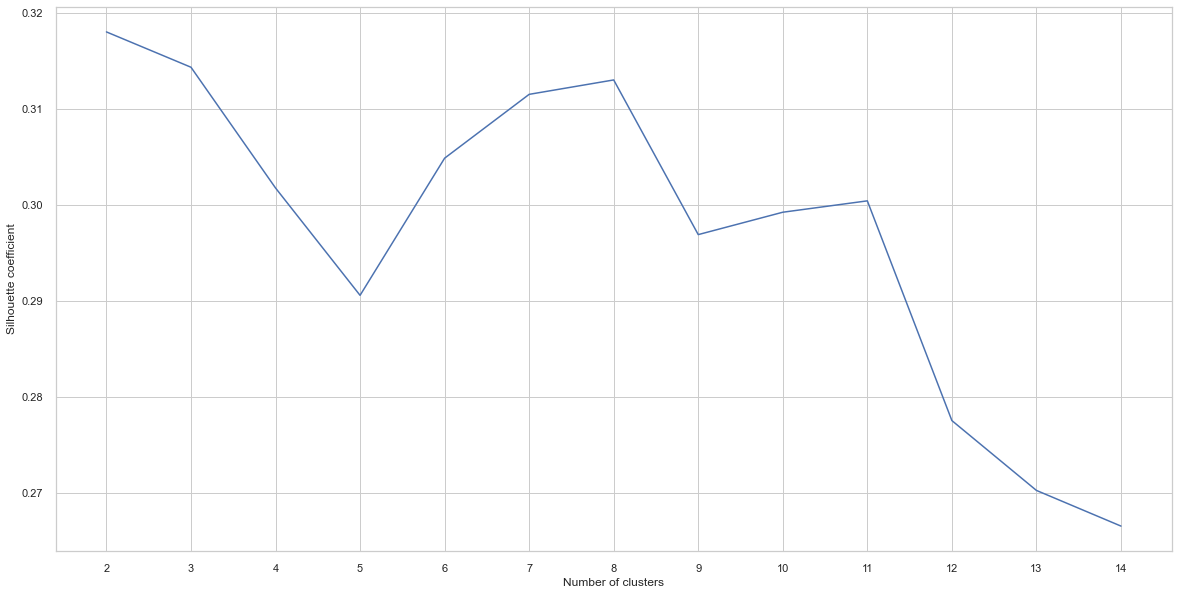

In [17]:
# plot silhouette coefficients for each k
plt.figure(figsize=(20, 10))
plt.plot(range(2, 15), silhouette_coefficients)
plt.xticks(range(2, 15))
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette coefficient")
plt.show()

In [18]:
# cluster data for the chosen number of clusters
k = 8
k_means_new = KMeans(k)

kmeans.fit(scaled_df)

clustered_data = df.copy()
clustered_data['cluster'] = k_means_new.fit_predict(scaled_df)

clustered_data

,id,vehicleType,dist_center_start,dist_center_end,duration,cluster
120814,ZnJlZWZsb2F0OjpjYXIyZ286OldEQzE1Njk0MjFKNjEyMjMw,car,1986,3290,20.000000,6
60088,ZnJlZWZsb2F0OjpjYXIyZ286OldERDE3NzA0NDFKMTEwOTcz,car,4756,1625,50.016667,1
46984,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMjkzMDI4,car,4353,525,40.000000,1
146684,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLNDA4MzE1,car,2169,2844,30.000000,6
198253,ZnJlZWZsb2F0OjpjYXIyZ286OldNV1hSMTEwMDBURTU3ODA0,car,1586,2935,25.033333,6
...,...,...,...,...,...,...
71725,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMjczNjUw,car,1384,1149,64.716667,4
373590,YmlrZTo6dGllcjo6ZmZiNjJlZDctZjBiMi00OGMxLWE2NT...,scooter,4465,4396,9.966667,7
330644,YmlrZTo6dGllcjo6ZWQwNDdiMWQtZGQxYy00MTgzLTlhZm...,scooter,3646,571,25.016667,1
202888,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMzg0NTA5,car,1970,3675,50.016667,6


### Interpretation and visualization of results

In [19]:
# show cluster results for interpretation
clustered_data.groupby(['cluster']).mean()

,dist_center_start,dist_center_end,duration
cluster,,,
0,1355.777660,1361.197856,14.797375
1,3472.255355,1556.108988,31.424790
2,6818.390756,2582.012605,40.621148
3,2508.404891,6711.657609,38.724072
4,2958.372432,2878.732273,92.895593
5,6506.833716,6515.133028,28.268196
6,1610.420355,3490.733866,28.920621
7,3710.696747,3724.828961,19.425314


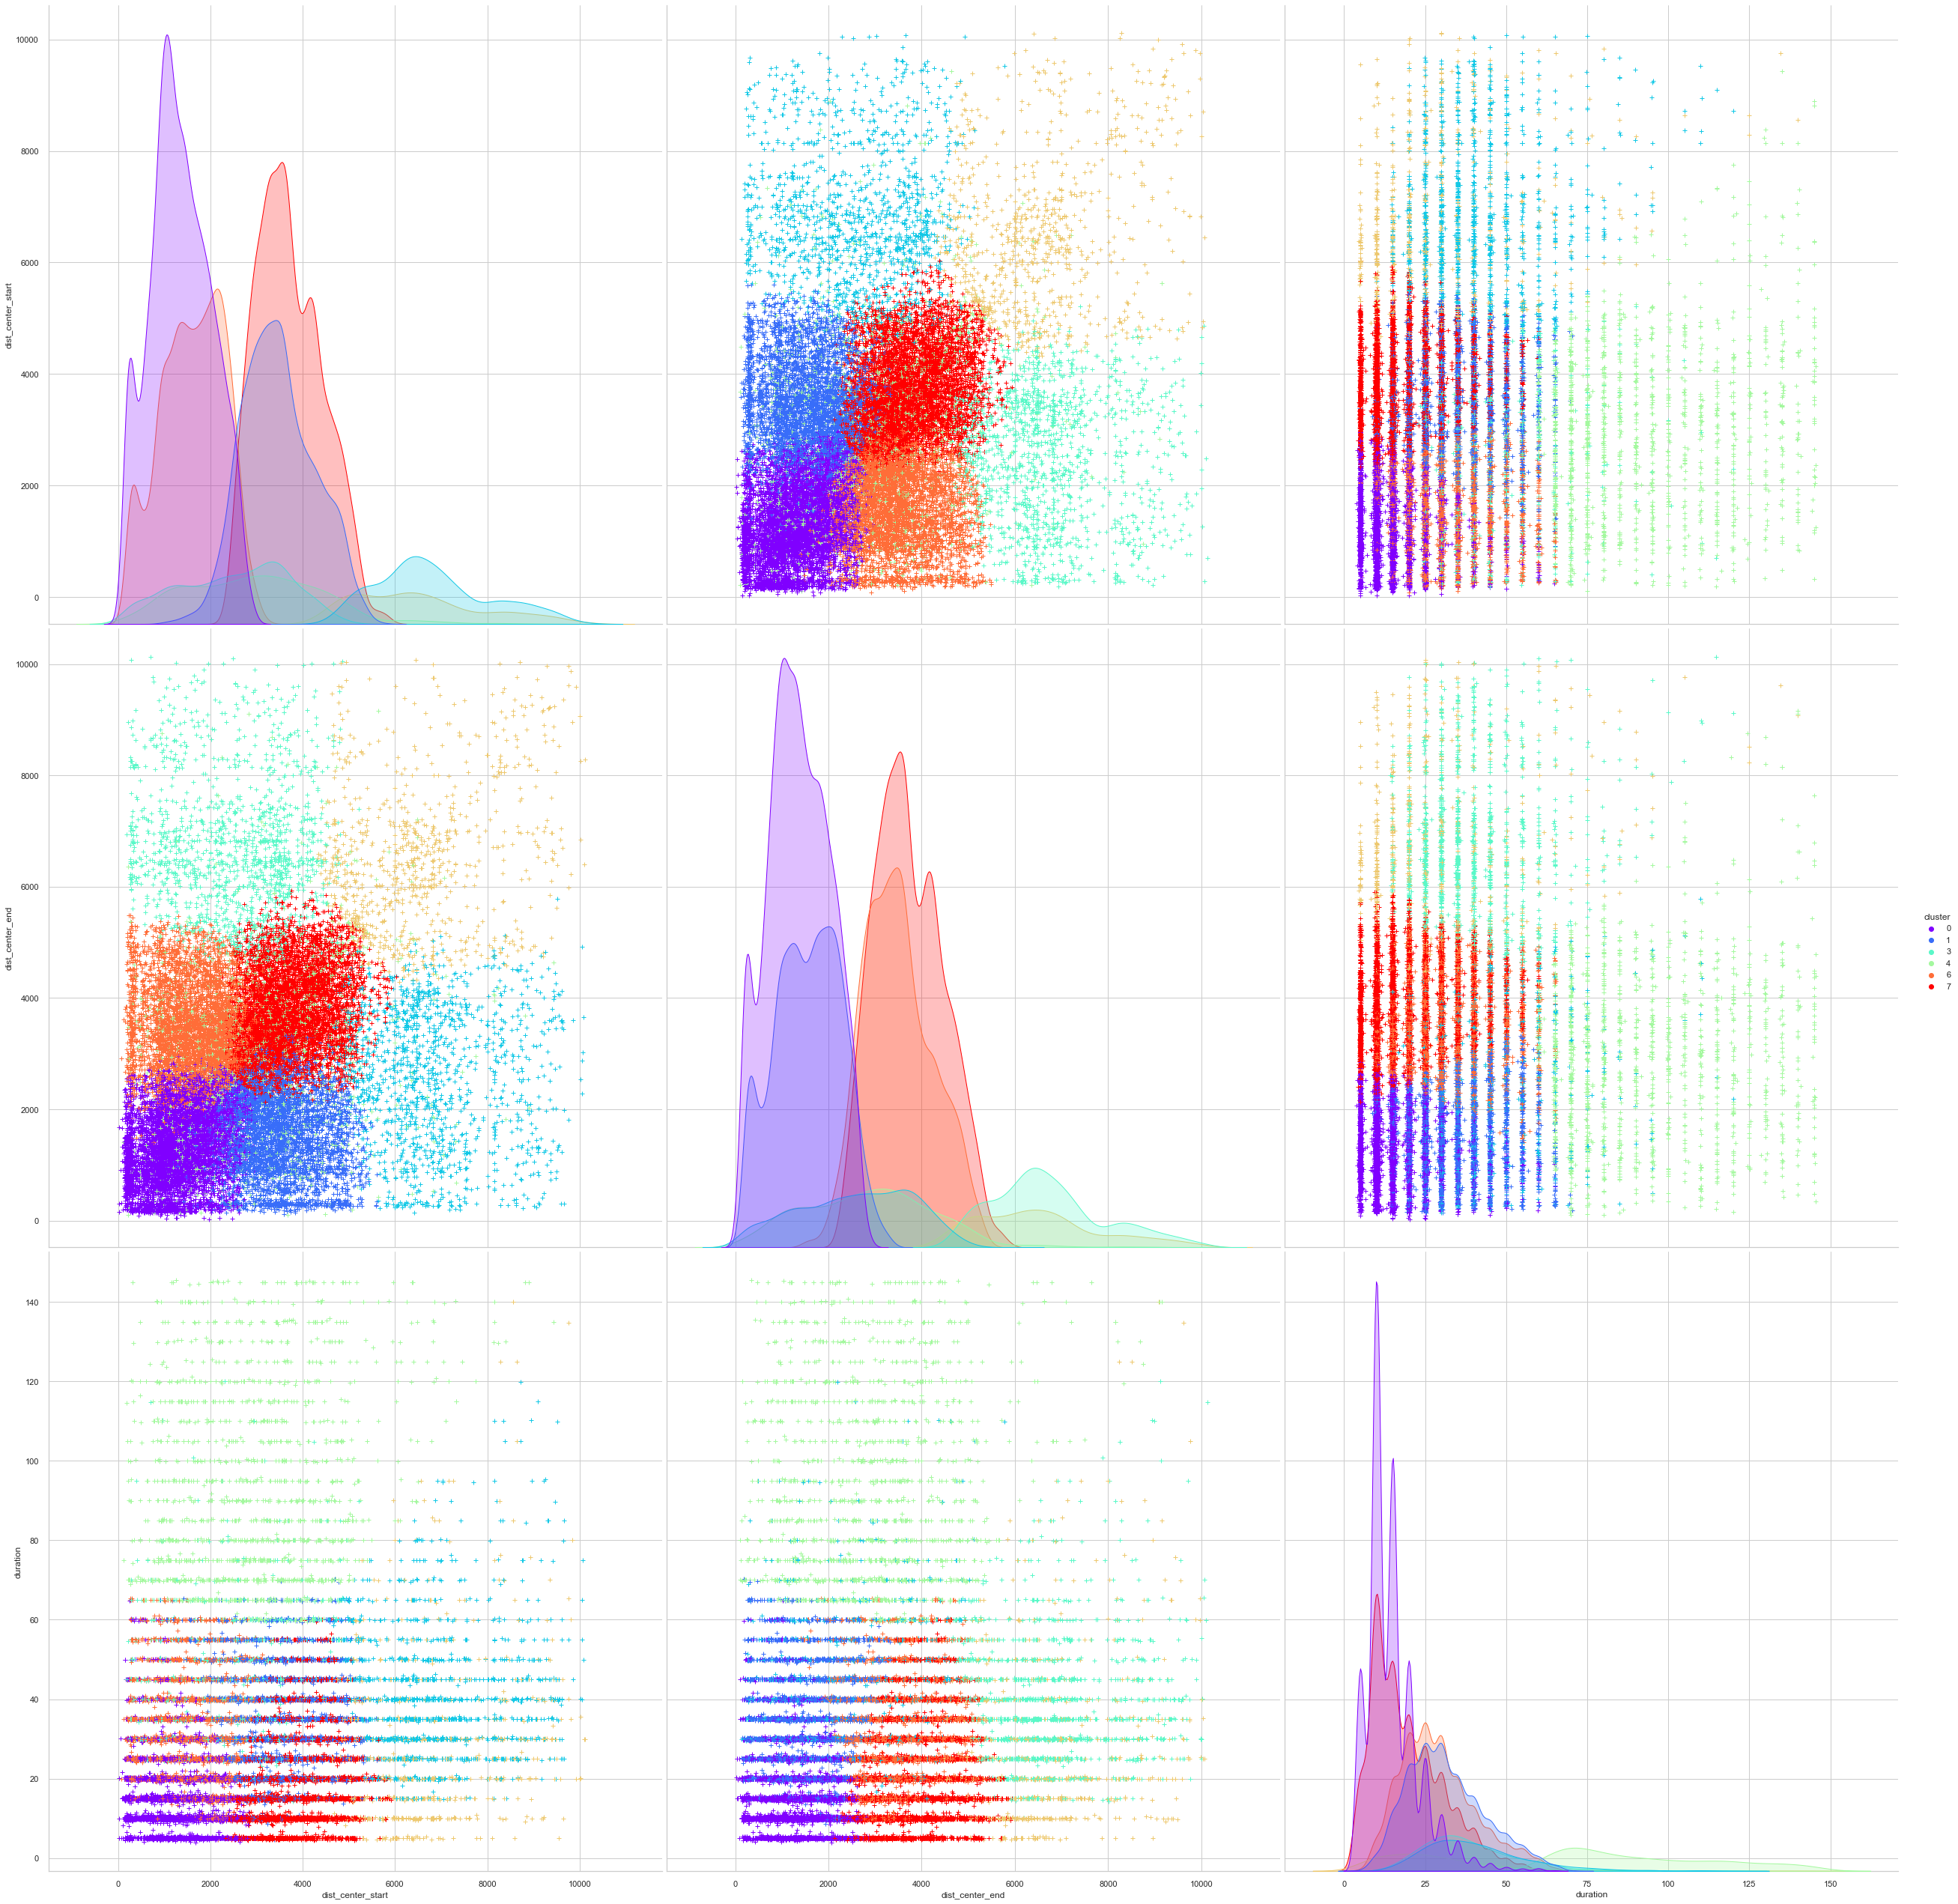

In [29]:
# plot cluster results
#g = sns.relplot(x="dist_center_start", y="duration", kind="scatter", data=clustered_data, legend='full', marker='+', hue='cluster', palette='rainbow', height=12, aspect=1)
sns.pairplot(clustered_data, hue="cluster", plot_kws=dict(marker="+", linewidth=1), palette='rainbow', height=12, aspect=1)

### Distribution of trip types among mobility modes

In [23]:
# show cluster distribution
clustered_data.groupby(['vehicleType','cluster']).describe()

dist_center_start                                    \
                                count         mean          std     min   
vehicleType cluster                                                       
bicycle     0                   689.0  1467.412192   663.322950    30.0   
            1                   318.0  3115.040881   572.068769  1066.0   
            2                     9.0  6077.777778   260.544995  5789.0   
            3                    10.0  2793.800000  1082.637602   784.0   
            4                   107.0  2263.485981  1013.144185   262.0   
            5                     5.0  6069.200000  1841.582662  4745.0   
            6                   344.0  1725.470930   665.588899   116.0   
            7                   447.0  3378.337808   574.961867  2399.0   
car         0                  1476.0  1459.417344   631.026249   140.0   
            1                  3901.0  3532.398359   803.193240  1045.0   
            2                  1391.0  6837.447879  1224.735161  4544.0   
            3                  1407.0  2495.598436  1165.926230   193.0   
            4                  1304.0  3096.913344  1464.180346   190.0   
            5                   731.0  6616.556772  1448.624039  4328.0   
            6                  3905.0  1593.563892   694.547159   193.0   
            7                  3519.0  3845.972151   703.760451  2333.0   
scooter     0                  5391.0  1313.134669   653.376701    23.0   
            1                   543.0  3249.375691   595.191788   922.0   
            2                    28.0  6109.714286   409.753029  5393.0   
            3                    55.0  2784.127273   963.096935   635.0   
            4                    98.0  1873.632653  1181.635573   116.0   
            5                   136.0  5933.161765   681.495689  4440.0   
            6                   880.0  1640.246591   610.948632    79.0   
            7                  2705.0  3589.635860   686.042529  2244.0   

                                                       dist_center_end  \
                         25%     50%      75%      max           count   
vehicleType cluster                                                      
bicycle     0        1019.00  1445.0  1994.00   2883.0           689.0   
            1        2684.75  3108.0  3556.00   4668.0           318.0   
            2        5827.00  6074.0  6367.00   6417.0             9.0   
            3        1898.25  3371.0  3610.75   3704.0            10.0   
            4        1405.50  2360.0  3098.00   4239.0           107.0   
            5        4957.00  5276.0  6146.00   9222.0             5.0   
            6        1224.25  1868.0  2257.75   3124.0           344.0   
            7        2941.00  3305.0  3709.50   5207.0           447.0   
car         0         971.75  1477.0  1963.00   2970.0          1476.0   
            1        2941.00  3490.0  4115.00   5806.0          3901.0   
            2        5998.50  6681.0  7539.00  10076.0          1391.0   
            3        1561.50  2583.0  3435.00   5209.0          1407.0   
            4        1988.75  3103.0  4093.25   9428.0          1304.0   
            5        5306.50  6432.0  7561.00  10113.0           731.0   
            6        1072.00  1608.0  2150.00   3299.0          3905.0   
            7        3292.00  3746.0  4382.50   5874.0          3519.0   
scooter     0         860.00  1244.0  1779.00   2966.0          5391.0   
            1        2911.00  3180.0  3564.50   5325.0           543.0   
            2        5832.00  6043.5  6467.25   6896.0            28.0   
            3        2193.00  2968.0  3498.50   4431.0            55.0   
            4         975.25  1544.0  2564.00   5125.0            98.0   
            5        5445.75  5997.0  6377.75   7846.0           136.0   
            6        1199.50  1744.5  2168.00   2713.0           880.0   
            7        3048.00  3526.0  4090.00   6030.0          2705.0

In [24]:
def create_distribution_overview(mode):
    
    distribution = clustered_data[clustered_data['vehicleType']==mode]

    distribution = distribution.groupby(['cluster']).count().copy()
    trip_volume = len(clustered_data[clustered_data['vehicleType']==mode])
    distribution['Distribution [%]'] = distribution['id'] / trip_volume *100

    return distribution[['Distribution [%]']]

In [25]:
create_distribution_overview('car')

,Distribution [%]
cluster,
0,8.370194
1,22.122037
2,7.888171
3,7.978904
4,7.394805
5,4.145401
6,22.144720
7,19.955767


In [26]:
create_distribution_overview('bicycle')

,Distribution [%]
cluster,
0,35.717989
1,16.485226
2,0.466563
3,0.518403
4,5.546916
5,0.259202
6,17.833074
7,23.172628


In [27]:
create_distribution_overview('scooter')

,Distribution [%]
cluster,
0,54.808865
1,5.520537
2,0.284669
3,0.559170
4,0.996340
5,1.382676
6,8.946726
7,27.501017
